In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

import sys
sys.path.append('../')
from src.attention import SelfAttention
from src.models import FBRNN,RNN
from src.helper import train

torch.manual_seed(1)

DATA_DIR = '../Data/'

Using TensorFlow backend.


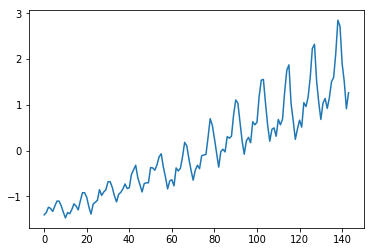

In [2]:
dataset = pd.read_csv(DATA_DIR+'international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = (dataset - dataset.mean()) / dataset.std() # RNN's are sensitive to non-standardized data
plt.plot(dataset)
plt.show()

In [3]:
batch_size = 1

sample_batch = torch.tensor(dataset.values)
sample_batch = sample_batch.view(144,1,1).type(torch.float32)

x_train = sample_batch[:100]
x_test = sample_batch[100:-1]

y_train = sample_batch[1:101]
y_test = sample_batch[101:]

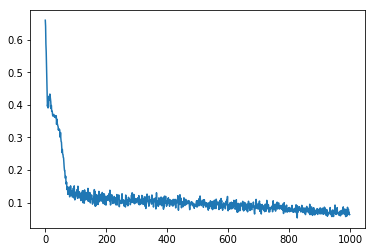

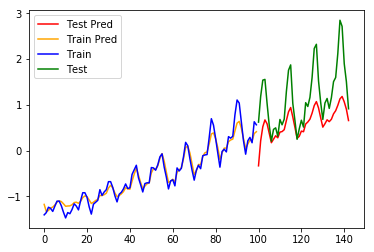

In [4]:
# testing basic RNN 
rnn = RNN(hidden_size=16,num_layers=3,feature_size=1,batch_size=1)

opt = optim.SGD(rnn.parameters(), lr = 0.01, momentum=0.9)
criterion = nn.MSELoss()

loss = train(rnn,x_train,y_train,criterion,opt,epochs=1000)
    
plt.plot(loss)
plt.show()

rnn.eval()
y_test_pred = torch.stack(rnn(x_test))
y_train_pred = torch.stack(rnn(x_train))

x=np.arange(100,143)
plt.plot(x,y_test_pred.detach().squeeze().numpy(), 'red',label='Test Pred') # detach is necessary because the output still has gradient tracking on it
x=np.arange(0,100)
plt.plot(x,y_train_pred.detach().squeeze().numpy(), 'orange',label='Train Pred') # detach is necessary because the output still has gradient tracking on it
x=np.arange(0,100)
plt.plot(x,x_train.squeeze().numpy(), 'blue',label='Train')
x=np.arange(100,143)
plt.plot(x,x_test.squeeze().numpy(), 'green',label='Test')
plt.legend()
plt.show()

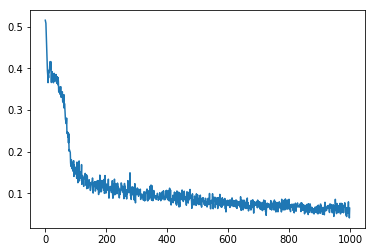

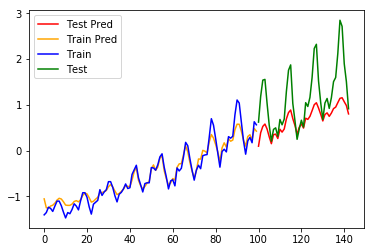

In [5]:
# testing custom RNN
fbrnn = FBRNN(hidden_size=16, num_layers=3, batch_size=1, feature_size=1, attention_hidden_size=10)

opt = optim.SGD(fbrnn.parameters(), lr = 0.01, momentum=0.9)
criterion = nn.MSELoss()

losses = train(fbrnn,x_train,y_train,criterion,opt,epochs=1000)
    
plt.plot(losses)
plt.show()

fbrnn.eval()
y_test_pred = torch.stack(fbrnn(x_test))
y_train_pred = torch.stack(fbrnn(x_train))

x=np.arange(100,143)
plt.plot(x,y_test_pred.detach().squeeze().numpy(), 'red',label='Test Pred') # detach is necessary because the output still has gradient tracking on it
x=np.arange(0,100)
plt.plot(x,y_train_pred.detach().squeeze().numpy(), 'orange',label='Train Pred') # detach is necessary because the output still has gradient tracking on it
x=np.arange(0,100)
plt.plot(x,x_train.squeeze().numpy(), 'blue',label='Train')
x=np.arange(100,143)
plt.plot(x,x_test.squeeze().numpy(), 'green',label='Test')
plt.legend()
plt.show()

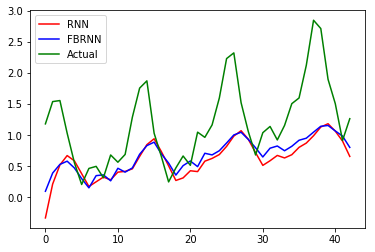

In [6]:
y_pred_basic = torch.stack(rnn(x_test))
plt.plot(y_pred_basic.detach().squeeze().numpy(), "red",label='RNN') # detach is necessary because the output still has gradient tracking on it
y_pred_custom = torch.stack(fbrnn(x_test))
plt.plot(y_pred_custom.detach().squeeze().numpy(), "blue",label='FBRNN') # detach is necessary because the output still has gradient tracking on it
plt.plot(y_test.squeeze().numpy(), "green", label='Actual')
plt.legend()
plt.show()

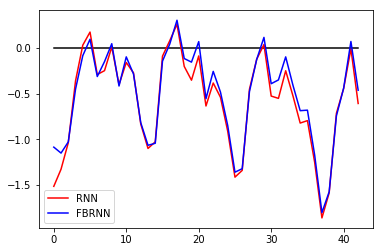

In [9]:
plt.plot(np.zeros(43), "black")
plt.plot(y_pred_basic.detach().squeeze().numpy() - y_test.squeeze().numpy(), "red",label='RNN')
plt.plot(y_pred_custom.detach().squeeze().numpy() - y_test.squeeze().numpy(), "blue",label='FBRNN')
plt.legend()
plt.show()